# Алгоритмы отбора моделей

В этой тетради мы изучим различные методы отбора наилучших моделей машинного обучения и их применение для улучшения производительности интерпретируемости моделей.

***

## Знакомство с методами

Ознакомимся с различными методами отбора признаков, такими как отбор признаков на основе важности, рекурсивное исключение признаков (Recursive Feature Elimination, RFE) и методы отбора признаков на основе моделей.

### Методы фильтрации

Методы фильтрации выбирают признаки на основе статистических показателей, таких как корреляция или критерий хи-квадрат. Эти методы включают:

* Выбор объектов на основе корреляции: Выбирает объекты на основе их корреляции с целевой переменной.
* Тест Chi2: Использует критерий хи-квадрат для выбора объектов на основе их взаимосвязи с целевой переменной.
* SelectKBest: Выбирает лучшие k объектов на основе статистических тестов.
* F-значение ANOVA: Выбирает объекты на основе их дисперсии и целевой переменной.

### Методы-оболочки

Методы-оболочки выбирают объекты путем оценки их комбинаций с использованием прогнозирующей модели. Распространенные примеры включают:

* Рекурсивное устранение признаков (RFE): Этот метод работает путем рекурсивного удаления наименее важных признаков на основе оценки важности модели. Он начинается со всего набора предикторов, вычисляет оценку важности для каждого предиктора, а затем удаляет наименее важные из них до тех пор, пока не будет найдено оптимальное подмножество.
* Обратное устранение признаков: Аналогично RFE, этот метод начинается со всех признаков и удаляет наименее значимый признак на каждой итерации, улучшая производительность модели до тех пор, пока не будет замечено никаких дальнейших улучшений.
* Прямой выбор функции: Итеративное добавление функции, которая наилучшим образом улучшает модель, до тех пор, пока не будет замечено никаких дальнейших улучшений.

### Встроенные методы

Встроенные методы выбирают функции, изучая их важность во время обучения модели. Примеры встроенных методов включают:

* Регрессия Лассо: Использует регуляризацию L1 для ограничения абсолютного размера коэффициентов, эффективно выполняя отбор признаков.
* Регрессия гребня: Использует регуляризацию L2 для уменьшения коэффициентов менее важных признаков.
* Важность объектов случайного леса: Древовидные методы, такие как Random Forest, предоставляют оценки важности объектов, которые можно использовать для выбора объектов.

C этой небольой теоритической основой можно приступать к практическим примерам.

***

## Практические примеры

Приступим теперь к практическим примерам применения некоторых методов отбора признаков в гипотетических задачах машинного обучения.

Cначала выполним все нужные импорты. Установим также случайный seed, введём тип, который очень быстро пригодится для сокращённых аннотаций типов.

In [1]:
from random import seed
from typing import Optional, Tuple

import matplotlib.pyplot as plt
from numpy import ndarray
from pandas import read_csv
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

seed(52)
TrainTestSplitTuple = Tuple[ndarray, ndarray, ndarray, ndarray]

Не помешает и функция для визуализации полученных результатов.

In [2]:
ThreeFloats = Tuple[float, float, float]


def visualize_results(
    figure_name: str,
    axes_names: Tuple[str, str],
    first_res: ThreeFloats,
    second_res: ThreeFloats,
    default_res: Optional[float],
    min_max: Tuple[float, float],
) -> None:
    figure, (axis_one, axis_two) = plt.subplots(1, 2)
    y_min, y_max = min_max
    axes_names = iter(axes_names)
    bar_names = tuple((f"score {n}" for n, _ in enumerate(first_res)))

    axis_one.bar(bar_names, first_res, color="tab:red", edgecolor="black")
    axis_two.bar(bar_names, second_res, color="tab:blue", edgecolor="black")
    for axis in (axis_one, axis_two):
        axis.set_title(next(axes_names))
        axis.set_ylim(y_min, y_max)
        if default_res is not None:
            axis.bar("default", default_res, color="tab:green", edgecolor="black")
        axis.grid(True)

    figure.suptitle(figure_name, fontsize=14)
    plt.tight_layout()
    plt.show()

Загрузим наши данные.

In [3]:
wine = read_csv("../datasets/winequality_red.csv")

wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Выполним рутинную предварительную обработку самых данных и запишем их в отдельную переменную.

In [4]:
x_train_wine, x_test_wine, y_train_wine, y_test_wine = train_test_split(
    wine.iloc[:, :-1],
    wine.iloc[:, -1],
    test_size=0.3,
    random_state=52,
)

scaler = MinMaxScaler()
scaler.fit(x_train_wine)
x_train_scaled = scaler.transform(x_train_wine)
x_test_scaled = scaler.transform(x_test_wine)
train_test_split_scaled = (x_train_scaled, x_test_scaled, y_train_wine, y_test_wine)

С обработанными данными уже можено работать. Однако перед этим вычислим общее количество признаков в наборе данных.

In [5]:
wine_n_features = len(wine.columns) - 1

wine_n_features

11

### Методы-оболочки

Рассмотрим на примере как применять методы-оболочки, а именно: `SelectFromModel` и `RFE`.

#### Селекция на основе модели

Чтобы выполнить селекцию для модели Логистической регрессии воспользуемся классом `SelectFromModel` и масштабированными данными. Посмотрим на точность модели на отобранных данных, когда максимальное количество отобранных признаков не может превышать половины от общего их количества.

In [6]:
def score_sfm_regression(train_test_split: TrainTestSplitTuple, max_features: int) -> float:
    x_train, x_test, y_train, y_test = train_test_split
    sfm_regression = SelectFromModel(LogisticRegression(), max_features=max_features)

    sfm_regression.fit(x_train, y_train)
    x_train_selected = sfm_regression.transform(x_train)
    x_test_selected = sfm_regression.transform(x_test)

    sfm_regression.estimator.fit(x_train_selected, y_train)
    score = float(sfm_regression.estimator.score(x_test_selected, y_test))
    return score


sfm_score_1 = score_sfm_regression(train_test_split_scaled, wine_n_features // 2)
sfm_score_1

0.5604166666666667

Взглянем на результат, который получится при вычитании четырёх общего количества признаков.

In [7]:
sfm_score_2 = score_sfm_regression(train_test_split_scaled, wine_n_features - 4)
sfm_score_2

0.5604166666666667

А вот значение при `max_features=wine_n_features - 3`:

In [8]:
sfm_score_3 = score_sfm_regression(train_test_split_scaled, wine_n_features - 2)
sfm_score_3

0.5604166666666667

И на данных, которые мы лишь масштабировали.

In [9]:
regressor = LogisticRegression()

regressor.fit(x_train_scaled, y_train_wine)
regressor_score = regressor.score(x_test_scaled, y_test_wine)

regressor_score

0.5666666666666667

Как это ни странно, выборка после селекции негативно сказалась на качестве модели...

#### Рекурсивное устранение компонент

Всё тоже повторим для RFE (Recurcive Feature Elimination), но теперь аргументы при инициализации будут другими. За максимально количество признаков, которое может быть оставлено отвечает аргумент _n_features_to_select_. Также добавился так называемый шаг (ключевой аргумент _step_), устанавливающий количество признаков, выбрасываемых после одной итерации оценки их значительности.

Начнём так же с половины от общего количества факторов.

In [10]:
def score_rfe_regression(train_test_split: TrainTestSplitTuple, n_features_to_select: int, step: int) -> float:
    x_train, x_test, y_train, y_test = train_test_split
    rfe_regression = RFE(
        LogisticRegression(),
        n_features_to_select=n_features_to_select,
        step=step,
    )

    rfe_regression.fit(x_train, y_train)
    x_train_selected = rfe_regression.transform(x_train)
    x_test_selected = rfe_regression.transform(x_test)

    rfe_regression.estimator.fit(x_train_selected, y_train)
    score = float(rfe_regression.estimator.score(x_test_selected, y_test))
    return score


rfe_score_1 = score_rfe_regression(
    train_test_split_scaled,
    n_features_to_select=wine_n_features // 2,
    step=1,
)
rfe_score_1

0.55625

Вычтем 4 из общего количества.

In [11]:
rfe_score_2 = score_rfe_regression(
    train_test_split_scaled,
    n_features_to_select=wine_n_features - 4,
    step=2
)
rfe_score_2

0.5604166666666667

А вот оценка при `n_features_to_select=wine_n_features - 2`:

In [12]:
rfe_score_3 = score_rfe_regression(
    train_test_split_scaled,
    n_features_to_select=wine_n_features - 2,
    step=3
)
rfe_score_3

0.5708333333333333

Вспомним результат ванильной Логистической регрессии.

In [13]:
regressor_score

0.5666666666666667

Теперь уже разница оценки говорит в пользу модели, обёрнутой в `RFE`.

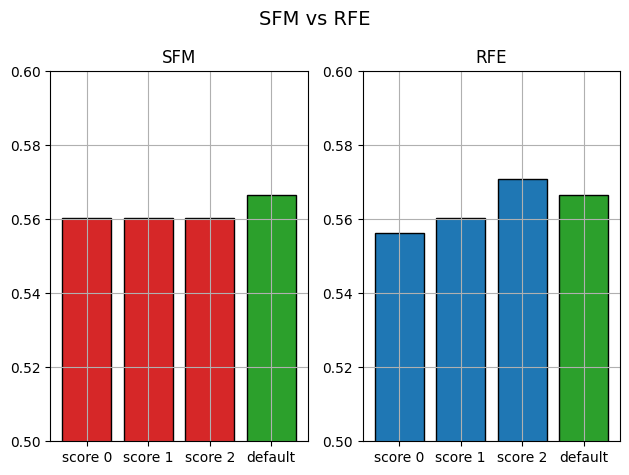

In [14]:
sfm_rfe_figure, sfm_rfe_axes = "SFM vs RFE", ("SFM", "RFE")
sfm_scores = (sfm_score_1, sfm_score_2, sfm_score_3)
rfe_scores = (rfe_score_1, rfe_score_2, rfe_score_3)
y_min_max = (0.5, 0.6)

visualize_results(sfm_rfe_figure, sfm_rfe_axes, sfm_scores, rfe_scores, regressor_score, y_min_max)

Как видно по вышеуказанному графику, для `SFM` оценка не отличается вовсе, а вот `RFE` довольно хорошо показал себя в последнем случае.

### Встроенные методы

Теперь рассмотрим, насколько эффективны встроенные методы, такие как: `Lasso` и `Ridge`. Случайный лес обозревать не будем, т.к. в предыдущих тетрадях итак хорошо описан принцип его работы. Лассо и Гребень (дословный перевод слова ridge) используют L1 и L2 метрики для регуляризации. Кратко уясним, что всё это значит.

Регуляризация L1 и L2 - это методы, используемые в машинном обучении для решения проблемы переобучения и выбора функций, особенно при работе с большим набором функций.

##### Регуляризация L1 (регрессия Лассо)
- Регуляризация L1, также известная как регрессия Лассо, добавляет абсолютное значение величины коэффициента в качестве штрафа.
- Она способствует разреженности и выбору признаков, сводя некоторые коэффициенты к нулю, тем самым отбирая наиболее релевантные признаки и снижая сложность модели
- Регуляризация L1 особенно полезна для выбора признаков при работе с данными большой размерности, поскольку позволяет выбрать подмножество наиболее важных атрибутов, снижая риск переобучения и упрощая понимание модели

##### Регуляризация L2 (регрессия гребня):
- В отличие от регуляризации L1, регуляризация L2 не приводит к тому, что коэффициенты должны быть точно равны нулю, а вместо этого делает их малыми.
- Это может предотвратить переобучение, распределяя влияние одной функции на несколько функций, и выгодно, когда есть корреляции между входными функциями 
- Регуляризация L2 приводит к более редкому решению по сравнению с регуляризацией L1

##### Сравнение
- Регуляризация L1 имеет встроенный выбор признаков, в то время как регуляризация L2 не выполняет выбор признаков, поскольку веса уменьшаются только до значений, близких к нулю, вместо нуля
- Регуляризация L1 устойчива к выбросам, в то время как регуляризация L2 — нет
- Регуляризация L1 требует больших вычислительных затрат, поскольку она не может быть решена с помощью матричной математики, в то время как регуляризация L2 требует меньших вычислительных затрат

Если совсем обобщить, получается, что мы как бы дополняем нашу функцию потерь. На языке математике это выглядит следующим образом.

Для Лассо:
$$
\textrm{L}(\overline{Y}, Y, W) = \frac{1}{n} \sum_{i = 1}^{n}{(\overline{y}_{i} - y_{i})^2} + \alpha \sum_{j = 1}^{m}{\left | w_{i} \right |},
$$
и для Гребня:
$$
\textrm{L}(\overline{Y}, Y, W) = \frac{1}{n} \sum_{i = 1}^{n}{(\overline{y}_{i} - y_{i})^2} + \alpha \sum_{j = 1}^{m}{w_{i}^{2}},
$$
где:
- $\overline{Y}$ — множество предсказаний модели,
- $Y$ — множество действительных значений целевой переменной,
- $W$ — множество всех весов,
- $n$ — количество измерений,
- $m$ — количество весов.

#### Лассо

Взглянем на результаты оценки регрессии Лассо. В качестве изменяемого параметра возьмём аргумент _alpha_ инициализатора `Lasso`. Сначала установим `alpha=0.01`.

In [15]:
def score_lasso_or_ridge(
    lasso_or_ridge: Lasso | Ridge,
    train_test_split: TrainTestSplitTuple,
    alpha: float,
) -> float:
    x_train, x_test, y_train, y_test = train_test_split
    instance = lasso_or_ridge(alpha=alpha)

    instance.fit(x_train, y_train)
    score = instance.score(x_test, y_test)
    return score


lasso_score_1 = score_lasso_or_ridge(Lasso, train_test_split_scaled, 0.01)
lasso_score_1

0.32968125841811013

Теперь посмотрим, как поведёт себя Лассо, если приравнять альфу к 0,01.

In [16]:
lasso_score_2 = score_lasso_or_ridge(Lasso, train_test_split_scaled, 0.001)
lasso_score_2

0.37617835460840254

И вот `alpha=0.001`:

In [17]:
lasso_score_3 = score_lasso_or_ridge(Lasso, train_test_split_scaled, 0.0001)
lasso_score_3

0.3732161017018373

Как видно, в данном случае меньшее значение _aplha_ обеспечивает лучшую оценку. Хотя для каждого конкретного случая нужно отдельно подбирать эту величину.

#### Гребень

Сейчас оценим эффективность регресии Гребня. Здесь аргументом остаётся уже знакомый нам параметр _alpha_. Начнём всё так же с 0,1.

In [18]:
ridge_score_1 = score_lasso_or_ridge(Ridge, train_test_split_scaled, 0.1)
ridge_score_1

0.3733575141054172

Оценим результат при альфе равной 0,01.

In [19]:
ridge_score_2 = score_lasso_or_ridge(Ridge, train_test_split_scaled, 0.01)
ridge_score_2

0.3731480869516366

И так же взглянем, что получится при `alpha=0.001`.

In [20]:
ridge_score_3 = score_lasso_or_ridge(Ridge, train_test_split_scaled, 0.001)
ridge_score_3

0.3731239574943809

В этот раз можно наблюдать наиболее высокую оценку при значении альфа равном 0,1.

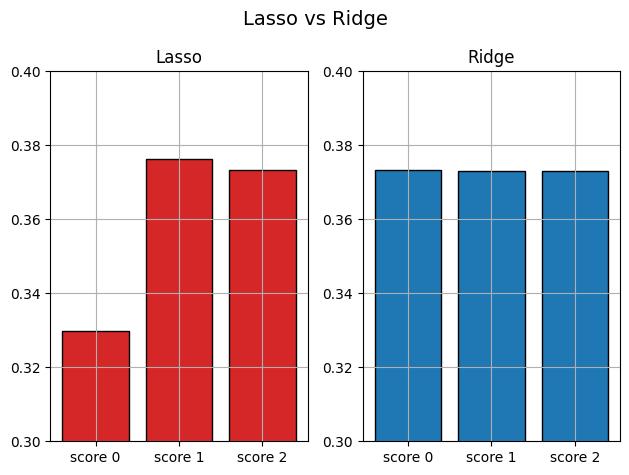

In [21]:
lasso_ridge_figure, lasso_ridge_axes = "Lasso vs Ridge", ("Lasso", "Ridge")
lasso_scores = (lasso_score_1, lasso_score_2, lasso_score_3)
ridge_scores = (ridge_score_1, ridge_score_2, ridge_score_3)
y_min_max = (0.3, 0.4)

visualize_results(
    lasso_ridge_figure,
    lasso_ridge_axes,
    lasso_scores,
    ridge_scores,
    default_res=None,
    min_max=y_min_max,
)

Теперь по рисунку, расположенному выше, можно судить, что `Lasso` лучше проявил себя на момент второй оценки, а вот `Ridge` практически никак не меняет своё значение.

***

## Заключение

В настоящей тетради мы познакомились с несколькими алгоритмами отбора моделей, а именно: селекцией на основе модели, рекурсивным устранением компонент, Лассо и Гребнем. Первые два относятся к методам-оболочкам, а вторые два — к встроенным методам.

В заключение можно ещё раз отметить, что алгоритмы отбора моделей суть очень полезный инструмент. Однако эффективность применения данного инструмента сильно зависит от конкретного случая и обстоятельств. Для каждых набора данных и модели требуется отдельно подбирать значения параметров и оценивать качество алгоритмов.